# Project Part I - Standard Collaborative Filtering


# 0. Introduction

In this report, I will walk you through my work process exploring the traditional collaborative filtering. I will include the steps to run my code and interpretation of the visualizations.

#### The Data Set
The dataset I am analyzing is from the [KKBox Music Recommendation Challenge Kaggle Competition](https://www.kaggle.com/c/kkbox-music-recommendation-challenge). For part 1, I am focusing my analysis on three variables in train.csv: user id, song id, and target, where:
- target=1: there are recurring listening event(s) triggered within a month after the user’s very first observable listening event. In the interpretation of this practice, it indicates a "like".
- target=0: otherwise

#### Thinking from a business perspective

From the data, I would like to construct a model to predict the likelihood that a user will listen to a song again after hearing it for the first time.

From a business standpoint, predicting and playing songs to users that they are most likely to enjoy and come back to listen to again will allow the business to increase user retention and thus revenue. With enough accuracy, the data would also inform other core metrics such as budgets for future initiatives, operational decisions such as what infrastructure is necessary to support the number of users during a specific period of time, and surface new marketing strategies such as advertising a music discovery feature to listeners.

On another hand, the model also predicts whether a user will churn. For example, if a user's predictions are all very low, then it's high chance that the user will churn. Identifying who is going to churn and when will alert the business to implement strategies to avoid such churns.

To achieve the above goals, I need to optimize the accuracy of my prediction model which will be measured by metrics such as overall accuracy, AUC, etc. However, I also want to ensure that the recommendations my model makes are not limited to the most popular items. For example, I want to give the users more, perhaps lesser-known options in order to create a more unique value proposition for the business. Therefore, I may need to trade off between accuracy and coverage to achieve the optimal result. 



#### The Approaches

In Project Part I, I will be exploring the traditional collaborative filtering and develop my own way of measuring its performance. The two common approaches are as follows:
- memory based: predictions for a specific item are based on similar items' ratings (item-based). When assessing the relationship between items, we have the following similarity measures: 
   - Pearson Correlation similarity
   - Cosine similarity 
   - Jaccard (excluded for this practice as it's for implicit data)
- model based: predictions are inferred from a model that is fit to approximate the data points (parameters will be learned from the training data set). In this practice, we will be exploring the matrix factorization approach.

Since collaborative filtering is an established technique, I want to use it as a reference for comparison with my original methods in Part II, and I will be using a public package for Part I. My first attempt was to use [Surprise](http://surpriselib.com) as it's one of the most popular packages for recommender systems implemented in python. However, after reading the documentation, it turns out that Surprise was not designed to support binary rating scale. Therefore, I decided on using [Graphlab](https://turi.com/products/create/docs/graphlab.toolkits.recommender.html), where I used _popularity-recommender_ as my baseline model, _item-similarity-recommender_ as my memory-based model and _ranking-factorization-recommender_ as my model-based model.

To make test statistics (accuracy, precision, recall, auc and coverage) comparable between the three models, I did not use the builtin _evaluate-precision-recall_ provided by GraphLab and instead built my own.
- accuracy: percentage of accurate predictions
- precision: true positive predictions over all positive predictions
- recall: true positive predictions over all relevant items
- auc: the area under the ROC curve 
- coverage: how well our recommendation set (items) represent the whole available item sets

Next, I will walk though the detailed code and my findings and conclusions at the end of this notebook.

#### 0.1 Set Up

In [2]:
import pandas as pd
import numpy as np
import graphlab
from graphlab import recommender as gl
import seaborn as sns
import matplotlib.pyplot as plt
import random
import time
%matplotlib inline
sns.set(style='whitegrid')

# 1. Data Preparation 

#### 1.1 Loading Data
For Project Part I, I am only focusing on the three fields: user_id, item_id and rating (1 or 0)

In [3]:
df=pd.read_csv("train.csv")
df= df[["msno","song_id","target"]]
df["msno"]=df["msno"].astype(str)
df["song_id"]=df["song_id"].astype(str)
df.columns = ['user_id', 'item_id',"rating"]

#### 1.2 Data Exploration
Here is a basic overview of our dataset

In [4]:
num_of_items=df.item_id.nunique()
num_of_users=df.user_id.nunique()
num_liked=df.loc[df["rating"]==1].shape[0]
print"# of users:",num_of_users
print"# of items:",num_of_items
print"# of likes:",num_liked
print"# of rows:", df.shape[0]

# of users: 30755
# of items: 359966
# of likes: 3714656
# of rows: 7377418


Usually, there are more users than items but in this case there are more items (~10 times more). The ratings are somewhat balanced as 51% user-item pair indicates a "like". To check the sparsity of the data, I can calculate its density as follows:

In [5]:
def cal_density(dataframe):
    num_item=dataframe.item_id.nunique()
    num_user=dataframe.user_id.nunique()
    den=float(dataframe.shape[0])/float((num_item*num_user))
    return den
print 'Original Density:',cal_density(df)

Original Density: 0.000666388014772


Only 0.067% of user-item pairs are rated - the data is very sparse.
To investigate further, I am interested in the frequency an item is rated and how it is distributed, i.e. if the long-tail problem exists

In [6]:
item_counts=df.item_id.value_counts().reset_index().rename(
    columns={'index': 'item_id', "item_id": 'count'})
user_counts=df.user_id.value_counts().reset_index().rename(
    columns={'index': 'user_id', "user_id": 'count'})

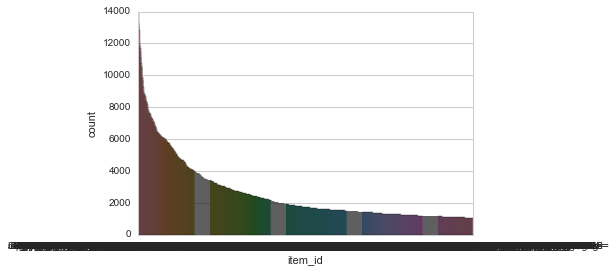

In [7]:
# plot histogram for counts
ax=sns.barplot(x="item_id",y="count",data=item_counts[:1000])#adding a limit here to avoid longer runtime

Given that the item_counts table is ordered (descending) and has 360,000 items, we can infer that the long tail problem exists heavily. In fact, to check number of items that were only rated once (or users only rated one item):

In [8]:
print "% of items rated once:",float(item_counts[item_counts["count"]==1].shape[0])/float(num_of_items)
print "% of users rated once:",float(user_counts[user_counts["count"]==1].shape[0])/float(num_of_users)

% of items rated once: 0.463282643361
% of users rated once: 0.0303040156072


Nearly half of the items were rated only once and 3% of the users have only rated 1 item. This reveals the cold-start problem which traditional CF does not solve. I will take this into consideration when I am sampling the data for training our models.

# 2. Sampling Data

As the density of the original data is 0.067%, I can not directly sample the data at random as it might result in a  recommendations with poor quality, due to the constraints of traditional CF. To solve this, I can increase the density of the data by restricting a minimum number of ratings an item and a user can have.

Since excluding a certain items might affect the number of ratings of the existing users, I came up with an iterative approach to continuously exclude items/users until all items and users satisfy the minimum number of ratings. 



In [9]:
#remove rare-rated items/users (reduce cold-start problem)
def exclude_coldstart(dataframe,min_user_per_item_thr,min_item_per_user_thr):
    min_user_per_item=0
    min_item_per_user=0
    count=1
    while min_user_per_item<min_user_per_item_thr and min_item_per_user<min_item_per_user_thr:

        print "**iteration",count,"starts!**"
        item_count=dataframe.groupby("item_id").count().reset_index()
        min_user_per_item=item_count["user_id"].min()
        item_qualify=item_count[item_count["user_id"]>=min_user_per_item_thr]
        item_list=item_qualify["item_id"]
        print "num of qualified items:", len(item_list)

        user_count=dataframe.groupby("user_id").count().reset_index()
        min_item_per_user=user_count["item_id"].min()
        user_qualify=user_count[user_count["item_id"]>=min_item_per_user_thr]
        user_list=user_qualify["user_id"]
        print "num of qualified users:", len(user_list)
        
        dataframe=dataframe.loc[(dataframe['item_id'].isin(item_list))&(dataframe["user_id"].isin(user_list))]
        count+=1
        print
        
    return dataframe
#exclude users/items that have less than 15 ratings       
df=exclude_coldstart(df,15,15)
print "updated density:",cal_density(df)

**iteration 1 starts!**
num of qualified items: 45874
num of qualified users: 25371

**iteration 2 starts!**
num of qualified items: 45760
num of qualified users: 24926

**iteration 3 starts!**
num of qualified items: 45655
num of qualified users: 24923

**iteration 4 starts!**
num of qualified items: 45653
num of qualified users: 24922

**iteration 5 starts!**
num of qualified items: 45653
num of qualified users: 24922

updated density: 0.00569694297236


After gaining the updated df (we can see the density level has increased as desired), I construct a list with unique users and sample a percentage of users proportional to the length of this list:

In [10]:
item_set=df.item_id.unique().tolist()
user_set=df.user_id.unique().tolist()

perc_range=[0.01,0.1,0.25,0.50,0.75]
samples=[]
#construct a list of samples
for i in perc_range:
    sample_from_user=random.sample(user_set, int(i*len(user_set)))
    df_sample=df.loc[(df['user_id'].isin(sample_from_user))]
    samples.append(df_sample)

Let's take a look at the number of unique items/users in each sample:

In [11]:
print "%users","#items","#users"
for i in range(0,len(samples)):
    print int(perc_range[i]*100),"% ",samples[i]["item_id"].nunique()," ",samples[i]["user_id"].nunique()

%users #items #users
1 %  18393   249
10 %  43238   2492
25 %  45562   6230
50 %  45653   12461
75 %  45653   18691


As stated in the project instruction, we can start with a small sample for the analysis and I chose the first sample (at 1% user level) to continue.

#### 2.1 cross-validation set up
Here, I construct a random split with 80% to be training set and 20% to be test set and this will be my cross-validation set up.

In [12]:
sf_sample = graphlab.SFrame(data=samples[0])
sf_train, sf_test = sf_sample.random_split(.8)
print "sample density:",cal_density(samples[1])
print "# rows train",len(sf_train), "# rows test",len(sf_test)

sample density: 0.00599093657361
# rows train 52210 # rows test 13059


# 3. A First Attempt on Collaborative Filtering
Next, we start building the CF models!
- For baseline model, I am using a popularity based model where each item's rating is dependant on its frequency in the user-item pairs. In the end, I will recommend the top-n most popular items to all users.
- For item_based model, I set the pearson smilarity type and a default 64 top k nearest neightbors for calculating ratings.
- For model_based model, I set the number of latent factors and regularization term to their default values, and indicate the rating scale is binary. I will also be using the stochastic gradient descent as my solver.

In [13]:
baseline= gl.popularity_recommender.create(sf_train, target='rating',verbose=False)

Recsys training: model = popularity

In [14]:
item_based= gl.item_similarity_recommender.create(sf_train, target="rating",similarity_type='pearson',verbose=False)

Recsys training: model = item_similarity

In [15]:
model_based= gl.ranking_factorization_recommender.create(sf_train, target='rating',num_factors=32,regularization=1e-08,
                                                 binary_target=True,
                                                 solver = 'sgd',verbose=False)

Recsys training: model = ranking_factorization_recommender

# 4. Evaluation Metrics

So how did those model perform? Before answering that, I will need to construct the performance metrics as follows:

In [16]:
# This function calculates the accuracy
# The inputs are two arrays: actual ratings and predicted ratings
# The output is a list of three metrics: accuracy, precision and recall
def cal_accuracy(rating,pred):
    correct_count = 0
    true_positive = 0
    positive_pred = 0
    positive_rating = 0
    for i in range(len(rating)):
        if pred[i] == rating[i]:
            correct_count += 1.0
        if rating[i] == 1 and pred[i] == 1:
            true_positive +=  1.0
        if pred[i] == 1:
            positive_pred += 1.0
        if rating[i] == 1:
            positive_rating += 1.0
    
    accuracy = float("{0:.3f}".format(correct_count / len(rating)))
    #to avoid division by zero error
    if positive_pred==0:
        precision=0
    else:
        precision = float("{0:.3f}".format(true_positive / positive_pred))
    recall = float("{0:.3f}".format(true_positive / positive_rating))
    return [accuracy,precision,recall]


In [17]:
# This function calculates the area under ROC curve
# The inputs are two arrays: actual ratings and predicted ratings
# The output is the calculated auc result
def cal_auc(rating, pred):
    auc =  graphlab.evaluation.auc(rating, pred)
    return auc

In [18]:
# This function calculates the catelog coverage 
# The inputs are: the model we trained, the test dataset and number of recommendations we make for each user
# The output is a result of catelog coverage 
def cal_coverage(model,test,num_k):
    recs= float(model.recommend(users=test['user_id'],k=num_k,items=test["item_id"],verbose=False).to_dataframe().item_id.nunique())
    all = float(test.to_dataframe().item_id.nunique())
    return recs/all

In [19]:
# This function converts predicted probabilities to binary ratings and 
# evaulate and complie to a result output
def evaluate(model,test,threshold,num_k):
    model_pred=model.predict(test)
    rating = test.select_column('rating')
    binary_pred = [1 if i> threshold else 0 for i in model_pred]
    result=[i for i in cal_accuracy(rating,binary_pred)]
    result.append(float("{0:.3f}".format(cal_auc(rating,model_pred))))
    result.append(float("{0:.3f}".format(cal_coverage(model,test,num_k))))
    return result
    

Now let's evaluate the three models with a default threshold set as 0.5 and number of recommendations to be 20:

In [20]:
baseline_result=evaluate(baseline,sf_test,0.5,20)
item_result=evaluate(item_based,sf_test,0.5,20)
model_result=evaluate(model_based,sf_test,0.5,20)

print "accuracy","precision","recall","auc","coverage"
print baseline_result
print item_result
print model_result

accuracy precision recall auc coverage
[0.553, 0.579, 0.733, 0.546, 0.062]
[0.574, 0.616, 0.633, 0.558, 0.107]
[0.535, 0.792, 0.23, 0.633, 0.106]


Here we can see that both the model-based and item-based models are better than the baseline. What happens if we change some of the hypterparameters? How can we improve even more of these two models?

# 5. Tuning Hyperparameters
Below are the hyperparameters I identified to tune:
- item_based model:
    - number of nearest neighbors considered: num_k
    - similarity type: "pearson" or "cosine"
- model_based model:
    - number of latent factors: num_fac
    - regularization parameter (Interaction term): reg
- classification threshold: n

In [21]:
# This function takes in a list of different choice of a parameter (k-nearest neighbors or similarity type)
# and outputs a dataframe capturing the evaluation metrics at different choices of the parameter
def evaluate_item_param(k_range,similarity_type,threshold,num_rec):
    if type(k_range) is list:
        param=k_range
        eval=np.zeros(shape=(len(k_range),5))
        for i in range(0,len(k_range)):
            item_based= gl.item_similarity_recommender.create(
                sf_train, target="rating",similarity_type=similarity_type,verbose=False,only_top_k=k_range[i])
            eval[i]= evaluate(item_based,sf_test,threshold,num_rec)
        
    elif type(similarity_type) is list:
        param=similarity_type
        eval=np.zeros(shape=(len(similarity_type),5))
        for i in range(0,len(similarity_type)):
            item_based= gl.item_similarity_recommender.create(
                sf_train, target="rating",similarity_type=similarity_type[i],verbose=False,only_top_k=k_range)
            eval[i]= evaluate(item_based,sf_test,threshold,num_rec)
    else:
        "Please review and change your input"
        
    df_param=pd.DataFrame({"param":param,"accuracy": eval[:,0],"precision":eval[:,1],
                           "recall":eval[:,2],"auc":eval[:,3],"coverage":eval[:,4]})
    df_param=df_param[["param","accuracy","precision","recall","auc","coverage"]]
    return df_param

For k nearest neighbors, we explore the values from 40 to 600 and for the similarity types, we explore both pearson and cosine:

In [22]:
item_df_k=evaluate_item_param([40,80,160,300,500,600],"pearson",0.5,20)
item_df_similarity=evaluate_item_param(300,["pearson","cosine"],0.1,20)

Recsys training: model = item_similarity

Recsys training: model = item_similarity

Recsys training: model = item_similarity

Recsys training: model = item_similarity

Recsys training: model = item_similarity

Recsys training: model = item_similarity

Recsys training: model = item_similarity

Recsys training: model = item_similarity

In [23]:
item_df_k

,param,accuracy,precision,recall,auc,coverage
0,40,0.573,0.616,0.629,0.558,0.104
1,80,0.576,0.617,0.636,0.559,0.107
2,160,0.578,0.618,0.641,0.559,0.103
3,300,0.578,0.618,0.640,0.560,0.107
4,500,0.578,0.619,0.642,0.560,0.104
5,600,0.579,0.619,0.641,0.560,0.110


In [24]:
item_df_similarity

,param,accuracy,precision,recall,auc,coverage
0,pearson,0.573,0.589,0.784,0.560,0.108
1,cosine,0.453,0.798,0.029,0.621,0.139


Next, let's plot out the results:

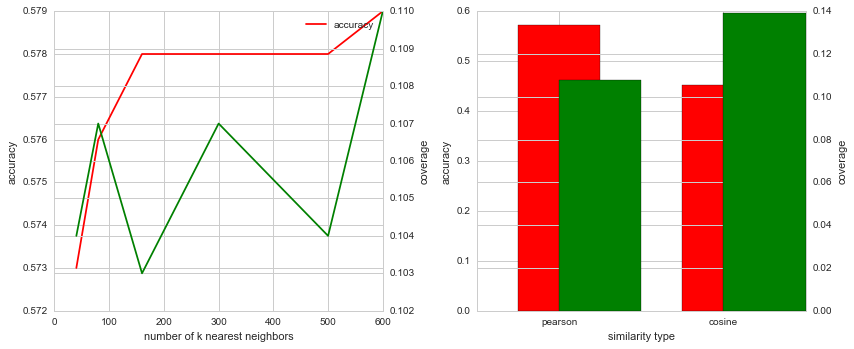

In [27]:
fig, axes = plt.subplots(1,2, figsize = (12,5))

# plotting metrics as k nearest neighbors changes
axes[0].plot(item_df_k["param"], item_df_k["accuracy"], color="red",label="accuracy")
ax2 = axes[0].twinx()
ax2.plot(item_df_k["param"], item_df_k["coverage"],color="green",label="coverage")
ax2.set_ylabel('coverage')
axes[0].set( xlabel = "number of k nearest neighbors", ylabel = "accuracy")

# plotting metrics given different similarity types
x_axis=np.arange(len(item_df_similarity["param"]))
axes[1].bar(x_axis, item_df_similarity["accuracy"], width=0.5,color="red",align="center",label="accuracy")
ax3 = axes[1].twinx()
ax3.bar(x_axis, item_df_similarity["coverage"],width=0.5,color="green",align="edge",label="coverage")
axes[1].set_xticks(x_axis)
axes[1].set_xticklabels(item_df_similarity["param"])
ax3.set_ylabel('coverage')
axes[1].set( xlabel = "similarity type", ylabel = "accuracy")
axes[0].legend()
axes[1].legend()
plt.tight_layout()


From the plots for item_based model, we can see that both accuracy and coverage increases as number of k nearest neighbors increases; the accuracy is higher given pearson similarity while cosine similarity gives a higher coverage. Therefore, we can conclude that a higher k and the pearson similarity form an optimal choice for the parameters, though the choice of pearson might suffer in coverage to some extent.

In [28]:
# This function takes in a list of different choices of a parameter (num of latent factors or regularization terms)
# and outputs a dataframe capturing the evaluation metrics at different choices of the parameter
def evaluate_factorization_param(n_fac,reg,threshold,num_rec):
    if type(n_fac) is list:
        param=n_fac
        eval=np.zeros(shape=(len(n_fac),5))
        for i in range(0,len(n_fac)):
            model_based=gl.ranking_factorization_recommender.create(
                sf_train, target='rating',num_factors=n_fac[i], regularization=reg,
                binary_target=True,solver = "sgd",verbose=False)
            eval[i]= evaluate(model_based,sf_test,threshold,num_rec)
    elif type(reg) is list:
        param=reg
        eval=np.zeros(shape=(len(reg),5))
        for i in range(0,len(reg)):
            model_based=gl.ranking_factorization_recommender.create(
                sf_train, target='rating',num_factors=n_fac, regularization=reg[i],
                binary_target=True,solver = "sgd",verbose=False)
            eval[i]= evaluate(model_based,sf_test,threshold,num_rec)   
    else:
        "Please review input"
        
    df_param=pd.DataFrame({"param":param,"accuracy": eval[:,0],"precision":eval[:,1],
                           "recall":eval[:,2],"auc":eval[:,3],"coverage":eval[:,4]})
    df_param=df_param[["param","accuracy","precision","recall","auc","coverage"]]
    return df_param

For number of latent factors, we explore the values from 10 to 60 and for regularization parameters, we explore values from 1e-11 to 1e-7:

In [29]:
fac_df_n=evaluate_factorization_param([10,20,30,60],1e-08,0.5,20)
fac_df_reg=evaluate_factorization_param(10,[1e-11,1e-10,1e-09,1e-08,1e-07],0.5,20)

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

In [30]:
fac_df_n

,param,accuracy,precision,recall,auc,coverage
0,10,0.546,0.762,0.273,0.647,0.175
1,20,0.522,0.782,0.203,0.638,0.185
2,30,0.536,0.786,0.234,0.633,0.105
3,60,0.533,0.789,0.226,0.634,0.105


In [31]:
fac_df_reg

,param,accuracy,precision,recall,auc,coverage
0,1.000000e-11,0.542,0.764,0.263,0.646,0.170
1,1.000000e-10,0.547,0.763,0.275,0.647,0.175
2,1.000000e-09,0.547,0.761,0.277,0.643,0.171
3,1.000000e-08,0.547,0.761,0.277,0.644,0.173
4,1.000000e-07,0.548,0.772,0.273,0.652,0.173


Next, let's plot out the results:

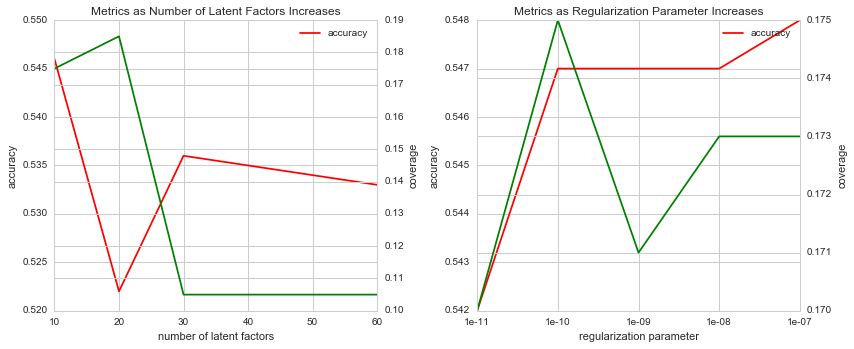

In [32]:
fig, axes = plt.subplots(1,2, figsize = (12,5))
#plotting metrics as number of latent factors changes
axes[0].plot(fac_df_n["param"], fac_df_n["accuracy"], color="red",label="accuracy")
ax2 = axes[0].twinx()
ax2.plot(fac_df_n["param"], fac_df_n["coverage"],color="green",label="coverage")
ax2.set_ylabel('coverage')
axes[0].set( xlabel = "number of latent factors", ylabel = "accuracy")
axes[0].set_title("Metrics as Number of Latent Factors Increases")
axes[0].legend()

#plotting metrics as ragularization parameter changes
x_axis=np.arange(len(fac_df_reg["param"]))
axes[1].plot(x_axis, fac_df_reg["accuracy"], color="red",label="accuracy")
axes[1].set_xticks(x_axis)
axes[1].set_xticklabels(fac_df_reg["param"])
ax3 = axes[1].twinx()
ax3.plot(x_axis, fac_df_reg["coverage"],color="green",label="coverage")
ax3.set_ylabel('coverage')
axes[1].set( xlabel = "regularization parameter", ylabel = "accuracy")
axes[1].set_title("Metrics as Regularization Parameter Increases")
axes[1].legend()
plt.tight_layout()

From the plots above for model-based model, we can see that the accuracy and coverage have an inverse relationship though both peaked at n=10; The accuracy increases as regularization parameter increases while coverage first increases and then decreases, followed by another increase. Considering all patterns for both accuracy and coverage, we can conclude that a number of latent factors at 10 and a regularization parameter at 1e-07 form an optimal choice for the parameters.

In [33]:
# This function takes in a range of choices of threshold and evaluates the model performances 
def evaluate_threshold(thresh):
    eval1=np.zeros(shape=(len(thresh),5))
    eval2=np.zeros(shape=(len(thresh),5))
    for i in range(0,len(thresh)):
        model_based=gl.ranking_factorization_recommender.create(
                sf_train, target='rating',num_factors=10, regularization=1e-07,
                binary_target=True,solver = "sgd",verbose=False)
        item_based= gl.item_similarity_recommender.create(
                sf_train, target="rating",similarity_type="pearson",verbose=False,only_top_k=300)
        eval1[i]= evaluate(model_based,sf_test,threshold[i],20)
        eval2[i]= evaluate(item_based,sf_test,threshold[i],20)
    df_param=pd.DataFrame({"param":thresh,"accuracy_model": eval1[:,0],"accuracy_item":eval2[:,0]})
    df_param=df_param[["param","accuracy_model","accuracy_item"]]
    return df_param

We construct the threshold to be 0.1,0.2....0.9 and evaluate which choice results in better performance of both model based and item-based models:

In [34]:
threshold=[float("{0:.1f}".format(i*0.1)) for i in range(1,10)]
thre_df=evaluate_threshold(threshold)

Recsys training: model = ranking_factorization_recommender

Recsys training: model = item_similarity

Recsys training: model = ranking_factorization_recommender

Recsys training: model = item_similarity

Recsys training: model = ranking_factorization_recommender

Recsys training: model = item_similarity

Recsys training: model = ranking_factorization_recommender

Recsys training: model = item_similarity

Recsys training: model = ranking_factorization_recommender

Recsys training: model = item_similarity

Recsys training: model = ranking_factorization_recommender

Recsys training: model = item_similarity

Recsys training: model = ranking_factorization_recommender

Recsys training: model = item_similarity

Recsys training: model = ranking_factorization_recommender

Recsys training: model = item_similarity

Recsys training: model = ranking_factorization_recommender

Recsys training: model = item_similarity

In [35]:
thre_df

,param,accuracy_model,accuracy_item
0,0.1,0.578,0.573
1,0.2,0.570,0.575
2,0.3,0.564,0.573
3,0.4,0.549,0.575
4,0.5,0.541,0.578
5,0.6,0.541,0.547
6,0.7,0.531,0.498
7,0.8,0.516,0.458
8,0.9,0.491,0.443


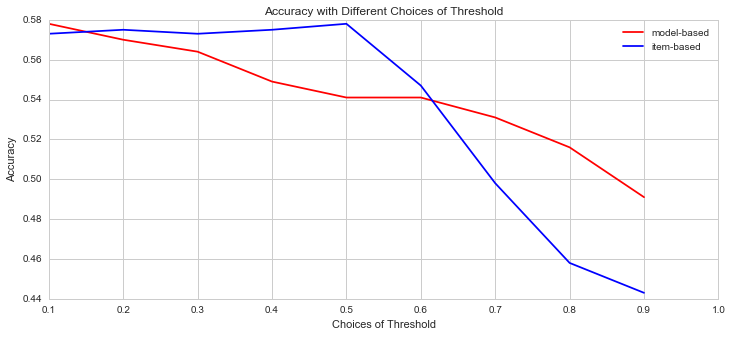

In [36]:
# let's plot out the results:
plt.figure(figsize = (12,5))
plt.plot(thre_df["param"], thre_df["accuracy_model"], label = "model-based", color = "red")
plt.plot(thre_df["param"], thre_df["accuracy_item"], label = "item-based", color = "blue")
plt.legend()
plt.title('Accuracy with Different Choices of Threshold')
plt.ylabel('Accuracy')
plt.xlabel('Choices of Threshold')


From the above chart, we can see that model-based model decreases as threshold increases while item-based model reachs a higher accuracy when threshold is set to 0.5 and decreases after 0.5. Therefore, we choose 0.5 as our optimal threshold.

So far, we have explored how accuracy/coverage metrics change as we tune the hyperparameters and have found a set of optimal parameters. However, what happens when we scale up our sample data size? Will it result in a different performance or an exponentially increasing runtime?

# 6. Changing Sample Size

Now, we take the formally constructed samples and record and measure both the performance and runtime of each sample size.

In [37]:
runtime_dict=dict()
runtime_list = []
metric_dict=dict()
metric_list=[]
#perform baseline model on different sample sizes
for i in samples:
    sf_sample = graphlab.SFrame(data=i)
    train, test = sf_sample.random_split(.8)
    start = time.time()
    baseline=gl.popularity_recommender.create(train, target='rating',verbose=False)
    end = time.time()
    runtime_list.append(end - start)
    result=evaluate(baseline,test,0.5,20)
    accuracy=result[0]
    coverage=result[-1]
    metric_list.append([accuracy,coverage])
runtime_dict['baseline'] = runtime_list
metric_dict["baseline"]=metric_list

#perform item_based model on different sample sizes
runtime_list = []
metric_list=[]
for i in samples:
    sf_sample = graphlab.SFrame(i)
    train, test = sf_sample.random_split(.8)
    start = time.time()
    item_based=gl.item_similarity_recommender.create(
        train, target="rating",similarity_type="pearson",verbose=False,only_top_k=300)
    end = time.time()
    runtime_list.append(end - start)
    result=evaluate(item_based,test,0.5,20)
    accuracy=result[0]
    coverage=result[-1]
    metric_list.append([accuracy,coverage])
metric_dict["item_based"]=metric_list
runtime_dict['item-based'] = runtime_list

#perform model_based model on different sample sizes
runtime_list = []
metric_list=[]
for i in samples:
    sf_sample = graphlab.SFrame(data=i)
    train, test = sf_sample.random_split(.8)
    start = time.time()
    model_based=gl.ranking_factorization_recommender.create(
                train, target='rating',num_factors=10, regularization=1e-08,
                binary_target=True,solver = "sgd",verbose=False)
    end = time.time()
    runtime_list.append(end - start)
    
    result=evaluate(model_based,test,0.5,20)
    accuracy=result[0]
    coverage=result[-1]
    metric_list.append([accuracy,coverage])
metric_dict["model_based"]=metric_list
runtime_dict['model-based'] = runtime_list

Recsys training: model = popularity

Recsys training: model = popularity

Recsys training: model = popularity

Recsys training: model = popularity

Recsys training: model = popularity

Recsys training: model = item_similarity

Recsys training: model = item_similarity

Recsys training: model = item_similarity

Recsys training: model = item_similarity

Recsys training: model = item_similarity

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

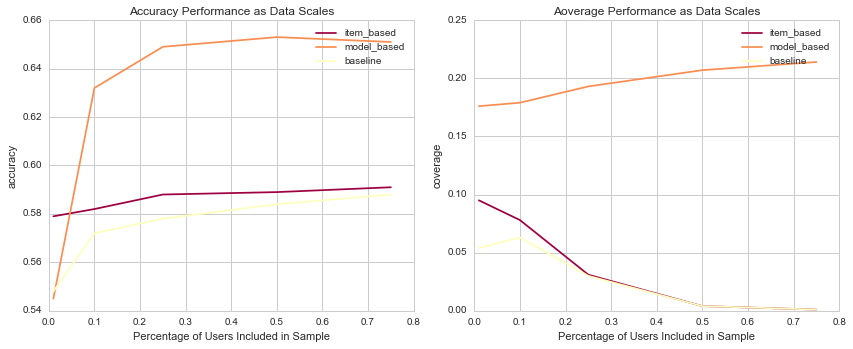

In [40]:
# let's plot out the metrics for all three models as data scales
perc_user = perc_range
colors=[plt.cm.Spectral(each) for each in np.linspace(0,1,len(perc_range))]

fig,axes=plt.subplots(1,2,figsize = (12,5))
for key, value, color in zip(metric_dict.keys(), metric_dict.values(), colors):
    axes[0].plot(perc_range, [i[0] for i in value], label = key, color = color)
axes[0].legend()
axes[0].set_title('Accuracy Performance as Data Scales')
axes[0].set_xlabel('Percentage of Users Included in Sample')
axes[0].set_ylabel('accuracy')

for key, value, color in zip(metric_dict.keys(), metric_dict.values(), colors):
    axes[1].plot(perc_range, [i[1] for i in value], label = key, color = color)
axes[1].legend()
axes[1].set_title('Aoverage Performance as Data Scales')
axes[1].set_xlabel('Percentage of Users Included in Sample')
axes[1].set_ylabel('coverage')
plt.tight_layout()


As data scales, the accuracy of all three models increases as data size increases. This is because more information about items/users is added to the data and the models can learn more from it (e.g. the model-based model can form more accurate latent factors). The converage, on the other hand, drops for both baseline and item_based model as the variety of their recommended items does not increase as much as the items in the whole dataset. Here, we see that the model_based model performs much better.
As a conclusion, the model-based approach out performs both the item-based and baseline models in both accuracy and coverage measurements.

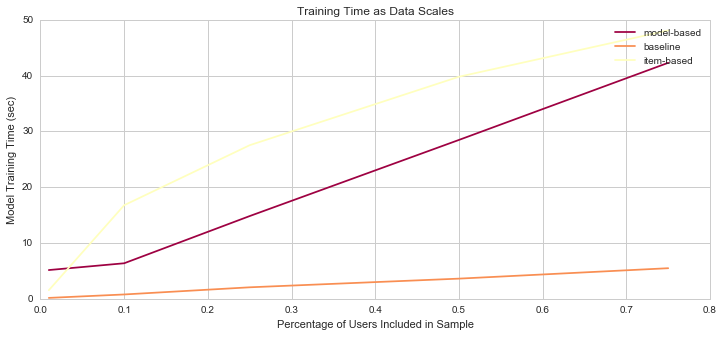

In [39]:
# let's plot out the run time results for all three models as data scales
perc_user = perc_range
colors=[plt.cm.Spectral(each) for each in np.linspace(0,1,len(perc_range))]

plt.figure(figsize = (12,5))
for key, value, color in zip(runtime_dict.keys(), runtime_dict.values(), colors):
    plt.plot(perc_range, value, label = key, color = color)
plt.legend()
plt.title('Training Time as Data Scales')
plt.xlabel('Percentage of Users Included in Sample')
plt.ylabel('Model Training Time (sec)')

As shown in the above graph, all three models' runtime increase as the data size increases. The model-based and baseline models' runtimes increase linearly with respect to input size (with the model-based model having a steeper slope) while the item-based model's runtime relative to input size is not as obvious. I would have expected an quadratic curve for the item-based model and to validate this I will increase the sample size in the next part of my project.

# 7. Takeaways

#### After seeing the above results about parameter tuning and data size scaling, I have the following takeaways:
- Initially, the overall accuracy was very low across all models with the highest accuracy being only 54%. Thus, I revisited the data to design a better way of sampling by continuously controlling the minumum number of ratings for items/users, thus increasing the density level. There might also exist other patterns of the data that can be improved.

- Though choosing a higher k parameter in the item-based model increases the accuracy, the coverage is much lower compared to the model-based approach and will result in a longer running time.

- After tuning the parameters further, the highest coverage I could attain was 20%. Since that is still very low, I need to consider other models to overcome this problem (e.g. leveraging content based recommendation).

- When the data size scales, the coverage rate of item-based model is lowered. We might be able to alleviate this by allowing the system to recommend more items to the users.

#### Given these takeaways, I might consider some other design choices:

- Explore the data more to uncover more patterns in the data: is it chronological ordered, what is the distribution of the users given demographic data, etc.

- Throw out outliers based on additional data fields, e.g. for users who have joined less than a week or users who have been on the platform for over years.

- I can preserve the similar distributions of my sampled data from the original data by leveraging stratified sampling on users' age, locations, etc. This will help with data scaling because as the data size increases, we can expect the similar properties of the data to persist.



#### Going back the the business case I illustrated at the beginning of this report, the traditional CF approach can meet the objectives only to a certain extent, for the following reasons:

- Given that models can give a 66% accuracy and a 20% coverage in the best case scenario, we can apply it when we can afford to recommend a large number of songs to the user, such as a discovery playlist. This means that 66% of the time, the users can consume our recommendations and they will outperform the baseline.

- However, if we want to give a more targeted recommendation (e.g. email campaign, recommend a song to listen next, etc), this accuracy level will not suffice since there is still a significant chance that our recommendation will fail.

- This model will also not resolve cold-start problems. Given that the data is very sparse -- a lot of songs are rarely rated and a lot of users have only rated a limited number of songs -- we will run into the cold start problem if we don't exclude those users/songs.

- The models seem to scale well since the runtime is linear relative to the input N, where N is the number of unique users. However, the models may scale differently when interpreting N as the number of rows in the dataset depending on data density.




In Project Part II, I will tackle the problems I mentioned above and incorporate the design considerations to implement an original recommender system